In [13]:
import sys

sys.path.append("../networks")
sys.path.append("../")

import sqlite3

import pandas as pd
import polars as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

from functions.datamodel import OptimumParameter
from functions.env import DB_SCIENCE_PATH, GRAPH_RESULTS, DB_SCIENCE_PATH_NEW
from functions.feat_network import get_edge_node_table
from functions.feat_visualization import sygma_graph_leiden

pd.options.mode.chained_assignment = None

conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)

from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

from sklearn.metrics.pairwise import euclidean_distances


def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)


In [14]:
## Load Data
path = 'europe_before_1700'

df = pd.read_csv(f"../networks/data/{path}.csv",index_col=[0])
df["meta_occupation"] = df["meta_occupation"].apply(lambda x: x.split(" | "))
df = df.explode("meta_occupation")
df = df[["wikidata_id", "meta_occupation"]]
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.columns = ["source", "target"]
df["weight"] = 1

## get co-occurence table
df = pl.from_pandas(df)
df_edge, df_nodes = get_edge_node_table(df)


df_edge_filter = df_edge[
    df_edge["rank_count"] <= 3
]

df_edge_filter.to_csv(f'edges_list_filtered/{path}.csv')

# visualization
df_partition, g = sygma_graph_leiden(
df_edge_filter,
df_nodes,
edge_bins=10,
node_bins=10,
filepath=f'final_graph/{path}.html')

In [15]:
## Load Data
path = 'non_europe_before_1700'

df = pd.read_csv(f"../networks/data/{path}.csv",index_col=[0])
df["meta_occupation"] = df["meta_occupation"].apply(lambda x: x.split(" | "))
df = df.explode("meta_occupation")
df = df[["wikidata_id", "meta_occupation"]]
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df.columns = ["source", "target"]
df["weight"] = 1

## get co-occurence table
df = pl.from_pandas(df)
df_edge, df_nodes = get_edge_node_table(df)


df_edge_filter = df_edge[
    df_edge["rank_count"] <= 3
]

df_edge_filter.to_csv(f'edges_list_filtered/{path}.csv')

# visualization
df_partition, g = sygma_graph_leiden(
df_edge_filter,
df_nodes,
edge_bins=10,
node_bins=10,
filepath=f'final_graph/{path}.html')

## Experimentation

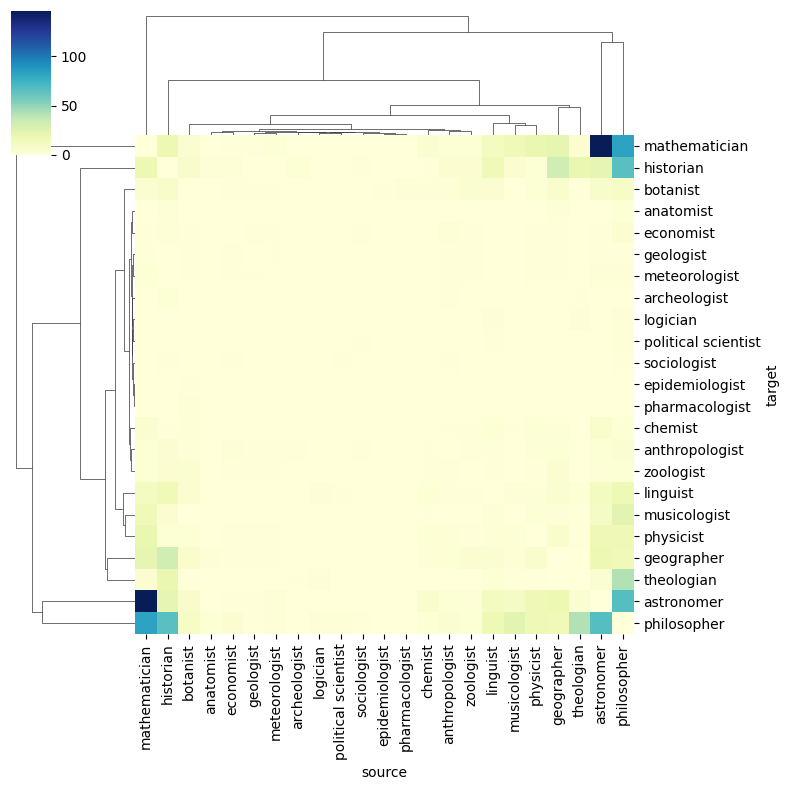

In [16]:
matrix = df_edge.pivot(columns="source", index="target", values="weight").fillna(0)

# Create a clustermap
sns.clustermap(matrix, cmap="YlGnBu", figsize=(8, 8))
plt.show()

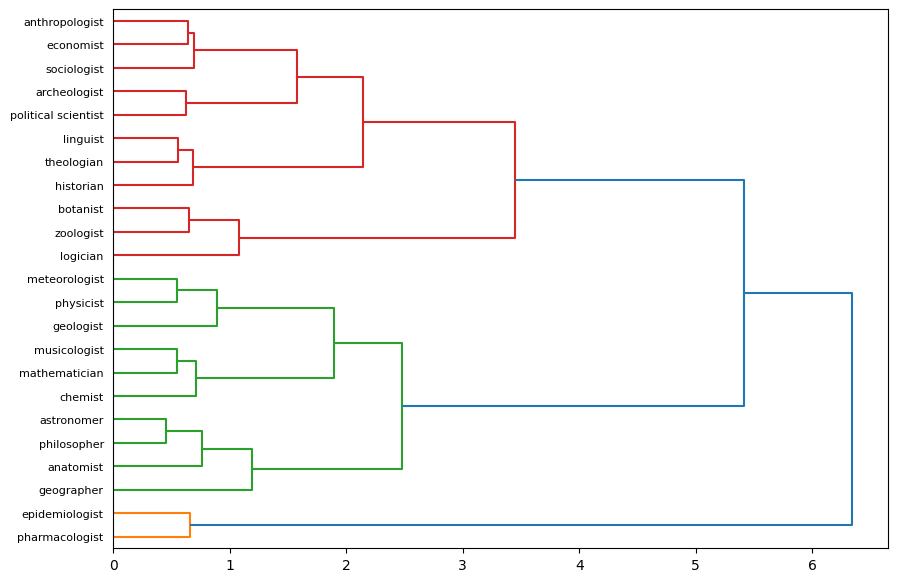

In [17]:
import networkx as nx
g = nx.from_pandas_edgelist(df_edge_filter)
pos = nx.spring_layout(g, seed = 41)

occupations = list(g.nodes())
similarity_matrix = np.zeros((len(occupations), len(occupations)))

for i, occupation_i in enumerate(occupations):
    for j, occupation_j in enumerate(occupations):
        pos_i = pos[occupation_i]
        pos_j = pos[occupation_j]
        pos_i = pos[occupation_i].reshape(1,-1)
        pos_j = pos[occupation_j].reshape(1,-1)
        similarity_matrix[i][j] = euclidean_distances(pos_i, pos_j)
        #similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)
similarity_df = 1-similarity_df

#df_pivot = df_edge_filter.pivot(index='source', columns='target', values='weight').fillna(0)

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

Z = linkage(similarity_df, 'ward')

plt.figure(figsize=(10, 7))
dendrogram(
    Z,
    labels=[str(node) for node in g.nodes],  # Convert node names to string if they aren't already
    #leaf_rotation=90,  # Rotates the x axis labels
    orientation='right',
    leaf_font_size=8.  # Font size for the x axis labels
)
plt.show()

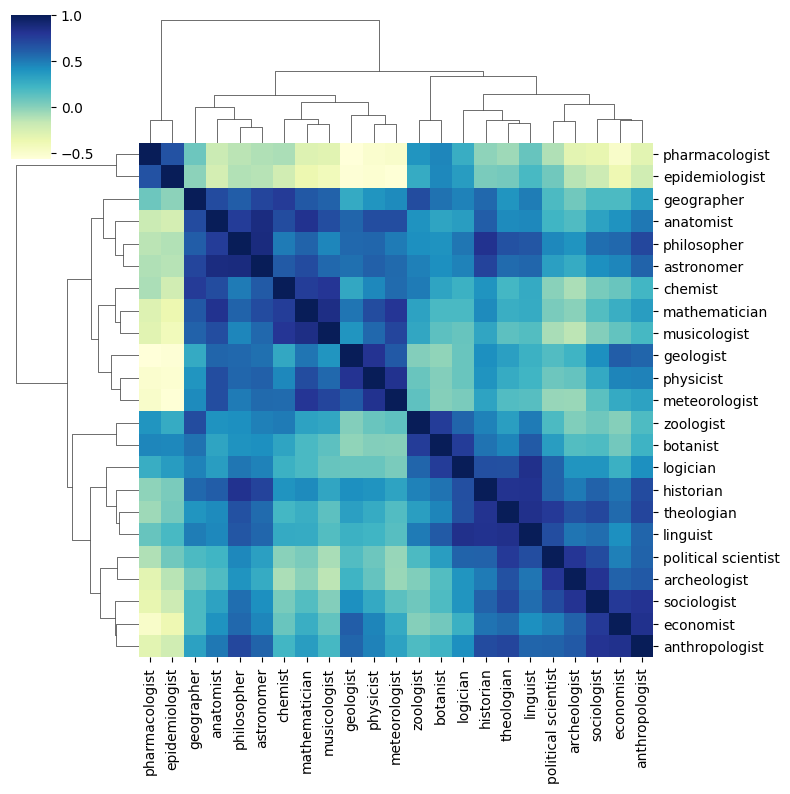

In [18]:

sns.clustermap(similarity_df, cmap="YlGnBu", figsize=(8, 8))
plt.show()

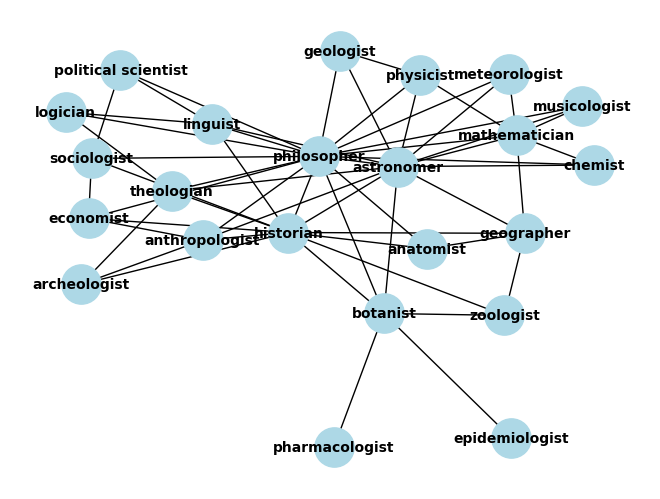

In [19]:
nx.draw(g, with_labels=True, node_color='lightblue', node_size=800, font_size=10, font_weight='bold')

In [20]:
"""df_final_edge = similarity_df.unstack().reset_index()
df_final_edge.columns = ['source', 'target','weight']
df_final_edge = df_final_edge[df_final_edge['source']!=df_final_edge['target']]

# Compute Count Ranking
df_final_edge = df_final_edge.sort_values(
    ["source", "weight"], ascending=(False, False)
).reset_index(drop=True)

df_final_edge["rank_count"] = df_final_edge.groupby(["source"])["weight"].rank(
    method="first", ascending=False)

df_final_edge = df_final_edge[df_final_edge['rank_count']<=3]

# visualization
df_partition, g = sygma_graph_leiden(
df_final_edge,
df_nodes,
edge_bins=10,
node_bins=10,
filepath='test.html')"""

'df_final_edge = similarity_df.unstack().reset_index()\ndf_final_edge.columns = [\'source\', \'target\',\'weight\']\ndf_final_edge = df_final_edge[df_final_edge[\'source\']!=df_final_edge[\'target\']]\n\n# Compute Count Ranking\ndf_final_edge = df_final_edge.sort_values(\n    ["source", "weight"], ascending=(False, False)\n).reset_index(drop=True)\n\ndf_final_edge["rank_count"] = df_final_edge.groupby(["source"])["weight"].rank(\n    method="first", ascending=False)\n\ndf_final_edge = df_final_edge[df_final_edge[\'rank_count\']<=3]\n\n# visualization\ndf_partition, g = sygma_graph_leiden(\ndf_final_edge,\ndf_nodes,\nedge_bins=10,\nnode_bins=10,\nfilepath=\'test.html\')'

In [21]:
"""# visualization
df_partition, g = sygma_graph_leiden(
df_edge_filter,
df_nodes,
edge_bins=10,
node_bins=10,
filepath='test.html')"""

"# visualization\ndf_partition, g = sygma_graph_leiden(\ndf_edge_filter,\ndf_nodes,\nedge_bins=10,\nnode_bins=10,\nfilepath='test.html')"